In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


INTRODUCTION


In [1]:
#importing libraries
import pandas as pd
import numpy as np
import datetime as date
import requests
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
from multiprocessing import  Pool

## https://psaw.readthedocs.io/en/latest/

In [ ]:
!pip install psaw

In [ ]:
from psaw import PushshiftAPI

In [ ]:
psaw_api = PushshiftAPI()

In [ ]:
date_start=int(date.datetime(2021,1,1).timestamp())
date_end=int(date.datetime(2021,2,1).timestamp())

In [ ]:
list_of_subreddits = ['meme','memes','4PanelCringe','teenagers','dankmemes','PrequelMemes','HistoryMemes','funny']

In [ ]:
data_feature = pd.DataFrame(columns=['author','created_utc','is_original_content','is_video','num_comments',
                                'over_18','subreddit','subreddit_subscribers','thumbnail','title','upvote_ratio', 
                                'url','thumbnail_height', 'thumbnail_width','score'])

In [ ]:
## https://psaw.readthedocs.io/en/latest/
for i in list_of_subreddits:
  request_api = psaw_api.search_submissions(subreddit = i,
                                                 after = date_start,
                                                 before = date_end,
                                                 filter=['author','created_utc','is_original_content','is_video','num_comments','over_18',
                                                         'subreddit','subreddit_subscribers','thumbnail','title','upvote_ratio', 'url',
                                                         'thumbnail_height', 'thumbnail_width','score'],
                                                 limit=35000)
  data_collection = pd.DataFrame([submission.d_ for submission in request_api])
  data_feature = pd.concat([data_feature, data_collection], ignore_index=True)

In [ ]:
data_feature.to_csv('data.csv', index=False)

In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/CS 2/data.csv")

In [ ]:
df1.shape

(209066, 16)

In [ ]:
img_data= df1[df1['url'].str.endswith(('jpg','png','jpeg'))]

In [ ]:
img_data.shape

(150588, 16)

In [ ]:
img_data = img_data[img_data['url'].str.startswith(('https'))]

In [ ]:
img_data.shape

(150588, 16)

In [ ]:
import multiprocessing
from multiprocessing import  Pool

In [ ]:
## Reference : https://medium.com/@nnamdi.okafor/using-python-to-check-status-codes-ef0133fe16d4
## https://stackoverflow.com/questions/1140661/what-s-the-best-way-to-get-an-http-response-code-from-a-url

In [ ]:
#Getting status code of each URLs. If status code is 200 then url is working otherwise not
def st_code(urls):
  code_of_url = []
  for k in tqdm(urls, position=0):
    try: 
      code_of_url.append(requests.get(k).status_code)
    except:
      code_of_url.append('error')
  return pd.DataFrame(code_of_url)

In [ ]:
#Reference : https://towardsdatascience.com/make-your-own-super-pandas-using-multiproc-1c04f41944a1
def data_parallelism(urls, function, n_cores=4):
    split_data = np.array_split(urls, n_cores)
    pool = Pool(n_cores)
    code_of_url = pd.concat(pool.map(function, split_data), ignore_index=True)
    pool.close()
    pool.join()
    return code_of_url

In [ ]:
code_of_url=data_parallelism(img_data['url'],st_code)

In [ ]:
img_data['st_code'] = 0

In [ ]:
img_data['st_code'] = code_of_url[0]

In [ ]:
#removing all data whose status code is not 200
img_data = img_data[img_data['st_code']==200]

In [ ]:
img_data.shape

In [ ]:
img_data.drop(['created','st_code','thumbnail','author'], axis=1,inplace=True)

In [ ]:
img_data.to_csv('final_data.csv')

In [ ]:
final_data= pd.read_csv('/content/drive/MyDrive/CS 2/final_data.csv')

In [ ]:
final_data.shape

(77373, 14)

Applying Sentiment score

In [ ]:
## https://medium.com/analytics-vidhya/sentiment-analysis-for-text-with-deep-learning-2f0a0c6472b5

In [ ]:
from tensorflow import keras
import json
from nltk.tokenize import RegexpTokenizer

#loading pre trained model and word index
LSTM_model = keras.models.load_model('/content/drive/MyDrive/CS 2/best_model.hdf5')
index_wrd = json.load(open("/content/drive/MyDrive/CS 2/word_idx.txt"))

In [ ]:
#function to compute sentiment score
def sentiment_score(LSTM_model, txt_data, index_wrd):

    list_txt = []
    pad_seq = len(txt_data)
    pad_len = np.zeros((56,pad_seq))

    dict_txt = [isinstance(item, (str, bytes)) for item in txt_data['title']]
    txt_data = txt_data.loc[dict_txt]

    for i, j in txt_data.iterrows():
        

        txt_col = txt_data['title'][i]
        
        # split the sentence into its words and remove any punctuations.
        tokenzz = RegexpTokenizer(r'\w+')
        list_txt_data = tokenzz.tokenize(txt_col)
        if len(list_txt_data)>56:
          list_txt_data = list_txt_data[:56]
          points = np.array(['1','2','3','4','5','6','7','8','9','10'], dtype = "int")
        
        # get index for the live stage
        ind_data = np.array([index_wrd[word.lower()] if word.lower() in index_wrd else 0 for word in list_txt_data])
        ind_data_ = np.array(ind_data)

        # padded with zeros of length 56 i.e maximum length
        pad_arr = np.zeros(56)
        pad_arr[:ind_data_.shape[0]] = ind_data_
        data_pad = pad_arr.astype(int)

        list_txt.append(data_pad)

    pad_len = np.asarray(list_txt)
    sent_score = LSTM_model.predict(pad_len, batch_size=64, verbose=0)
    sent_score1 = np.round(np.dot(sent_score, points)/10,decimals=2)
    sent_score2  = []
    for i in sent_score:

        three_top_idx = np.argsort(i)[-3:]
        three_top_scores = i[three_top_idx]
        three_top_wgts = three_top_scores/np.sum(three_top_scores)
        dot_prod = np.round(np.dot(three_top_idx, three_top_wgts)/10, decimals = 2)
        sent_score2.append(dot_prod)

    txt_data['Sentiment_Score'] = pd.DataFrame(sent_score2)

    return txt_data

In [ ]:
org_data = sentiment_score(LSTM_model, org_data, index_wrd)

In [ ]:
org_data= pd.read_csv('/content/drive/MyDrive/CS 2/org_data.csv')

In [ ]:
org_data.shape

(77373, 16)

In [ ]:
org_data.head()

,Unnamed: 0,Unnamed: 0.1,created_utc,is_original_content,is_video,num_comments,over_18,subreddit,subreddit_subscribers,title,upvote_ratio,url,thumbnail_height,thumbnail_width,score,Sentiment_Score
0,0,1,1612137510,False,False,4,False,meme,1407214,*Insert Random Pop Country Song*,0.90,https://i.redd.it/movwf3yzare61.jpg,136.0,140.0,26,0.43
1,1,2,1612137405,False,False,8,False,meme,1407215,"Finally, not a GameStop meme!",0.94,https://i.redd.it/7w63tapoare61.jpg,140.0,140.0,59,0.29
2,2,4,1612137318,False,False,2,False,meme,1407214,An interesting title,1.00,https://i.redd.it/hfo1at5fare61.png,140.0,140.0,1,0.63
3,3,6,1612137114,False,False,4,False,meme,1407211,Tomorrow $GME,0.89,https://i.redd.it/wly8hf7t9re61.jpg,98.0,140.0,18,0.49
4,4,11,1612136810,False,False,4,False,meme,1407210,Meme,1.00,https://i.redd.it/5izqa5vw8re61.png,140.0,140.0,1,0.50


Extracting text using OCR

In [ ]:
#installing pytesseract
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.8-py2.py3-none-any.whl size=14071 sha256=b39ffb0cf1179c137cc2fc228c37e55b0c9079c720aac3223c2d5409838935fb
  Stored in directory: /root/.cache/pip/wheels/a4/89/b9/3f11250225d0f90e5454fcc30fd1b7208db226850715aa9ace
Successfully built pytesseract


In [ ]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (29.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5

In [ ]:
#importing libraries
import cv2 
import pytesseract
from skimage import io
from google.colab.patches import cv2_imshow

In [ ]:
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

In [ ]:
org_data1=org_data.sample(n=13000,random_state=1,replace=False)

In [ ]:
org_data1.shape

(13000, 16)

In [ ]:
"""
This function will extract text from image. It takes url of image as input and
extracts text from image using pytesseract.
"""
def txt_extraction(urls):
  try:
    image = io.imread(urls)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY) 
    alpha_To_extract = r"--oem 3 --psm 11 -c tessedit_char_whitelist= 'ABCDEFGHIJKLMNOPQRSTUVWXYZ '"
    txt_data = pytesseract.image_to_string(image, lang='eng', config=alpha_To_extract)
    return txt_data.replace('\n', ' ')
  except:
    return " "

In [ ]:
def txt(org_data1):
  tqdm.pandas(position=0)
  img_txt = org_data1.progress_apply(txt_extraction)
  return img_txt

In [ ]:
#This function will help to parallelize our process
def data_parallelism(urls, function, n_cores=4):
    txt_split = np.array_split(urls, n_cores)
    pool = Pool(n_cores)
    img_txt = pd.concat(pool.map(function, txt_split))
    pool.close()
    pool.join()
    return img_txt 

In [ ]:
org_data1['img_txt']=0

In [ ]:
org_data1['img_txt'] = data_parallelism(org_data1['url'], txt)

100%|██████████| 3250/3250 [2:23:15<00:00,  2.64s/it]


In [ ]:
#Saving the dataset because these processes takes time, so that I don't have to do that in future
org_data1.to_csv("img_txt_data.csv")

In [ ]:
org_data = pd.read_csv('/content/drive/MyDrive/CS 2/img_txt_data.csv')

In [ ]:
org_data.shape

(13000, 18)

In [ ]:
#combining all text columns to one column and dropping the columns which are being combined
org_data['text'] = org_data['title']+org_data['img_txt']
org_data.drop(['title','img_txt'], axis=1, inplace=True)

In [ ]:
org_data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,created_utc,is_original_content,is_video,num_comments,over_18,subreddit,subreddit_subscribers,upvote_ratio,url,thumbnail_height,thumbnail_width,score,Sentiment_Score,text
0,2081,2081,3155,1611906658,False,False,4,False,meme,1396025,1.0,https://i.redd.it/wprmv4yj88e61.jpg,140.0,140.0,1,0.48,Hold or whatever
1,65458,65458,130121,1611250310,False,False,4,False,dankmemes,4363172,1.0,https://i.redd.it/tc4jtlaw0qc61.jpg,140.0,140.0,1,0.50,Who knew it was so easy?
2,33846,33846,52341,1611955374,False,False,2,False,memes,14613900,1.0,https://i.redd.it/qg9v80we9ce61.jpg,140.0,140.0,1,0.50,Here take a chocy milk calm yourselfon oy a ...
3,28979,28979,44404,1612035275,False,False,1,False,memes,14629522,1.0,https://i.redd.it/j6tryx10vie61.jpg,131.0,140.0,1,0.10,Haha billionaires badRedditors massively joini...
4,37316,37316,58041,1611920416,False,False,1,False,memes,14603384,1.0,https://i.redd.it/ah83g4ugd9e61.jpg,121.0,140.0,1,0.46,It happened today guysWhen the sun shines for ...


### <br><br>Cleaning text column
<br>

In [ ]:
#importing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re

In [ ]:
#downloading punkt and stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
#this function will take text as input and will clean it and return cleaned text
def clean_text(text):
    text = re.sub('[^A-Za-z]',' ',text).lower()    #Removing all characters from text except alphabets
    words = word_tokenize(text)
    stopWords = set(stopwords.words('english'))
    ps = PorterStemmer()
    cleanedText = []
    for word in words:
        word = ps.stem(word)
        if word in stopWords or len(word)<=4:      #Removing stopwords and words with length less than 5
            continue
        else:
            cleanedText.append(word)
    return " ".join(set(cleanedText))

In [ ]:
tqdm.pandas(position=0)
#calling function to clean the text
org_data['text'] = org_data['text'].progress_apply(clean_text)

100%|██████████| 13000/13000 [00:05<00:00, 2171.20it/s]


In [ ]:
#new feature containing number of words in text
org_data['num_words'] = org_data['text'].str.split().apply(len)

### **Extracting** **features**

In [ ]:
#importing libraries
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
import tensorflow as tf
# load the model


553476096/553467096 [==============================] - 5s 0us/step


In [ ]:
model_vgg = VGG16()

In [ ]:
#this function will take url of image as input and will get the image and convert it to array and return it
def load_image(link, target_size=None):
    import requests
    import shutil
    import os
    
    _, ext = os.path.splitext(link)
    
    r = requests.get(link, stream=True)
    with open('temp.' + ext, 'wb') as f:
        r.raw.decode_content = True
        shutil.copyfileobj(r.raw, f)
        
    img = image.load_img('temp.' + ext, target_size=target_size)
    return image.img_to_array(img)

In [ ]:
#this function will extract features and their probabilities from image and return them
def extract_feature_from_image(url):
  try:
    im = load_image(url, target_size=(224, 224))
    im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
    im = preprocess_input(im)
    yhat = model.predict(im)
    label = decode_predictions(yhat, top=3)
    obj = []
    pred = []
    for i in label[0]:
      obj.append(i[1])
      pred.append(i[2])
    return [obj,pred]
  
  except:
    return [[""]*3, [0]*3]

In [ ]:
tqdm.pandas(position=0)
img_feature_pred = org_data['url'].progress_apply(extract_feature_from_image)

  0%|          | 0/13000 [00:00<?, ?it/s]

49152/35363 [=========================================] - 0s 0us/step


100%|██████████| 13000/13000 [1:06:43<00:00,  3.25it/s]


In [ ]:
#creating new columns in the dataset to store new features
org_data['img_feature'] = np.empty(13000, dtype=object)
org_data['img_feature_pred'] = np.empty(13000, dtype=object)

In [ ]:
#adding newly generated features to the dataset
org_data['img_feature'] = [i[0] for i in img_feature_pred]
org_data['img_feature_pred'] = [i[1] for i in img_feature_pred]

In [ ]:
#Saving the dataset because these processes takes time, so that I don't have to do that in future
org_data.to_csv('df_img_feature_pred.csv',index=False)

### <br><br>Dropping Duplicates<br>
In this dataset we have many such rows in which urls are repeated means duplicate urls. Here I am going to drop such data.
<br>

In [ ]:
org_data = pd.read_csv('/content/drive/MyDrive/CS 2/df_img_feature_pred.csv')

In [ ]:
'''
Subreddits with more subscribers tend to get more upvotes, so I am normalizing the number of score by dividing by
the number of subscribers from the respective subreddit where it was posted.
'''
org_data['score'] = org_data['score']/org_data['subreddit_subscribers']

In [ ]:
'''
Checking percentile value of normalized score, so that I can get clear understanding for denoting meme 
as dank or not and making the problem as binary classification problem. 
'''
#checking for top 5 precentile value
top_5_percentile_value = []
for i in range(95,101):
  top_5_percentile_value.append(np.percentile(org_data['score'], i))
print(top_5_percentile_value)

[5.872748887997723e-06, 6.611864594333432e-06, 8.037597036952418e-06, 1.0170060120447284e-05, 1.6818461048757898e-05, 0.00741821464491812]


In [ ]:
between_97_98_percentile_value = []
for i in np.arange(0,1,0.1):
  between_97_98_percentile_value.append(np.percentile(org_data['score'], (97+i)))
print(between_97_98_percentile_value)

[8.037597036952418e-06, 8.078604300933008e-06, 8.219269094828569e-06, 8.350849157885698e-06, 8.736091145604518e-06, 8.817038200011783e-06, 9.027942768457746e-06, 9.4206476174494e-06, 9.506044727099957e-06, 9.92800809414098e-06]


In [ ]:
org_data['dank_or_not'] = (org_data['score']>np.percentile(org_data['score'], 97.1)).astype('int')

In [ ]:
org_data['dank_or_not'].value_counts()

0    12623
1      377
Name: dank_or_not, dtype: int64

In [ ]:
org_data.to_csv('org_data_dankornot.csv', index=False)

### <br><br>**Data cleaning and feature encoding**<br>
cleaning the dataset and encoding the categorical features of the dataset.
<br>


In [4]:
org_data = pd.read_csv('/content/drive/MyDrive/CS 2/org_data_dankornot.csv')

### Encoding created_utc column and creating new 'hour' column

The created_utc feature contains the timestamp when the post appeared on Reddit in the Coordinated Universal Time zone (UTC). Since most active Reddit users reside inthe USA, we converted this to North American Central Time Zone.

In [5]:
from datetime import datetime
from pytz import timezone
import pytz

In [6]:
fmt = "%Y-%m-%d %H:%M:%S %Z%z"

In [7]:
datetime_converted = org_data['created_utc'].apply(datetime.fromtimestamp)

In [8]:
datetime_converted=pd.DatetimeIndex(datetime_converted).tz_localize('UTC').tz_convert('America/New_York')

In [9]:
org_data['created_utc'] = pd.to_datetime(datetime_converted)

In [10]:
#creating hour column
org_data['hour'] = org_data['created_utc'].apply(lambda x: x.hour)

In [11]:
org_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype                           
---  ------                 --------------  -----                           
 0   Unnamed: 0             13000 non-null  int64                           
 1   Unnamed: 0.1           13000 non-null  int64                           
 2   Unnamed: 0.1.1         13000 non-null  int64                           
 3   created_utc            13000 non-null  datetime64[ns, America/New_York]
 4   is_original_content    13000 non-null  bool                            
 5   is_video               13000 non-null  bool                            
 6   num_comments           13000 non-null  int64                           
 7   over_18                13000 non-null  bool                            
 8   subreddit              13000 non-null  object                          
 9   subreddit_subscribers  13000 non-null  

In [12]:
org_data['is_video'].value_counts()

False    13000
Name: is_video, dtype: int64

In [13]:
org_data.drop(['is_video','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'], axis=1, inplace=True)

In [14]:
org_data.head()

,created_utc,is_original_content,num_comments,over_18,subreddit,subreddit_subscribers,upvote_ratio,url,thumbnail_height,thumbnail_width,score,Sentiment_Score,text,num_words,avg_h,avg_s,avg_v,img_feature,img_feature_pred,dank_or_not,hour
0,2021-01-29 02:50:58-05:00,False,4,False,meme,1396025,1.0,https://i.redd.it/wprmv4yj88e61.jpg,140.0,140.0,7.163196e-07,0.48,whatev,1,0,0,0,"['web_site', 'scoreboard', 'digital_clock']","[0.05935011, 0.047493964, 0.034131162]",0,2
1,2021-01-21 12:31:50-05:00,False,4,False,dankmemes,4363172,1.0,https://i.redd.it/tc4jtlaw0qc61.jpg,140.0,140.0,2.291911e-07,0.50,NaN,0,0,0,0,"['web_site', 'scoreboard', 'digital_clock']","[0.05935011, 0.047493964, 0.034131162]",0,12
2,2021-01-29 16:22:54-05:00,False,2,False,memes,14613900,1.0,https://i.redd.it/qg9v80we9ce61.jpg,140.0,140.0,6.842800e-08,0.50,yourselfon choci,2,0,0,0,"['Staffordshire_bullterrier', 'dalmatian', 'te...","[0.067652605, 0.06469549, 0.056321584]",0,16
3,2021-01-30 14:34:35-05:00,False,1,False,memes,14629522,1.0,https://i.redd.it/j6tryx10vie61.jpg,131.0,140.0,6.835493e-08,0.10,becau stonk massiv wallstreetbet badredditor b...,6,0,0,0,"['web_site', 'book_jacket', 'vizsla']","[0.9843156, 0.0043508904, 0.0033883443]",0,14
4,2021-01-29 06:40:16-05:00,False,1,False,memes,14603384,1.0,https://i.redd.it/ah83g4ugd9e61.jpg,121.0,140.0,6.847728e-08,0.46,guyswhen today happen januari first shine,6,0,0,0,"['web_site', 'book_jacket', 'Bouvier_des_Fland...","[0.86468834, 0.029700553, 0.0038205122]",0,6


In [15]:
org_data['text'] = org_data['text'].fillna("")

In [16]:
org_data[org_data['thumbnail_height'].isna()]

,created_utc,is_original_content,num_comments,over_18,subreddit,subreddit_subscribers,upvote_ratio,url,thumbnail_height,thumbnail_width,score,Sentiment_Score,text,num_words,avg_h,avg_s,avg_v,img_feature,img_feature_pred,dank_or_not,hour
49,2021-01-17 20:36:06-05:00,False,0,False,meme,1378429,1.0,https://i.redd.it/h6khrcfnvzb61.jpg,NaN,NaN,7.254636e-07,0.55,truegf alway annoy video,4,0,0,0,"['web_site', 'neck_brace', 'muzzle']","[0.27932075, 0.19540091, 0.09712952]",0,20
523,2021-01-29 08:19:04-05:00,False,0,False,memes,14604996,1.0,https://i.redd.it/bm3p9emuu9e61.png,NaN,NaN,6.846972e-08,0.44,grandma expect later watch batti todaya palat,7,0,0,0,"['book_jacket', 'comic_book', 'television']","[0.85341763, 0.050473444, 0.015581104]",0,8
2502,2021-01-18 10:00:05-05:00,False,2,False,dankmemes,4355381,1.0,https://imgur.com/gallery/EBeeGNE.jpg,NaN,NaN,2.296010e-07,0.30,scene,1,0,0,0,"['obelisk', 'brass', 'web_site']","[0.064340934, 0.042870212, 0.03823636]",0,10
2657,2021-01-28 16:58:44-05:00,False,0,False,memes,14589973,1.0,https://i.redd.it/g8xg85bwa5e61.jpg,NaN,NaN,6.854022e-08,0.51,,0,0,0,0,"['web_site', 'scoreboard', 'digital_clock']","[0.05935011, 0.047493964, 0.034131162]",0,16
2857,2021-01-29 12:36:04-05:00,False,0,False,memes,14609740,1.0,https://i.redd.it/vdulcf5r4be61.png,NaN,NaN,6.844749e-08,0.49,pathet thought upaat shield,4,0,0,0,"['comic_book', 'web_site', 'jigsaw_puzzle']","[0.40452492, 0.31786186, 0.1565833]",0,12
3066,2021-01-28 11:14:35-05:00,False,0,True,memes,14583538,1.0,https://i.redd.it/9se4slahl3e61.jpg,NaN,NaN,6.857047e-08,0.30,youtub studio antncio paseo money sonam adsyou...,10,0,0,0,"['web_site', 'television', 'iPod']","[0.94597846, 0.01150116, 0.004993559]",0,11
3303,2021-01-18 10:21:40-05:00,False,3,False,dankmemes,4355401,1.0,https://i.imgur.com/dlK7oeN.jpg,NaN,NaN,2.296000e-07,0.20,scene strike kidsain destroy pikachu mewtwo,7,0,0,0,"['sandal', 'pick', 'mouse']","[0.12178323, 0.054262247, 0.046235826]",0,10
3753,2021-01-14 00:04:54-05:00,False,2,False,meme,1372516,1.0,https://i.redd.it/x0z7gtmeiva41.jpg,NaN,NaN,7.285890e-07,0.45,spread,1,0,0,0,"['web_site', 'scoreboard', 'digital_clock']","[0.05935011, 0.047493964, 0.034131162]",0,0
3810,2021-01-21 23:08:08-05:00,False,9,False,PrequelMemes,1688571,1.0,https://i.redd.it/lubosb4f6tc61.jpg,NaN,NaN,5.922167e-07,0.49,,0,0,0,0,"['web_site', 'theater_curtain', 'groom']","[0.33447683, 0.09093042, 0.057228353]",0,23
3906,2021-01-05 02:22:22-05:00,False,19,False,meme,1358867,1.0,https://i.redd.it/1hr8kupktg961.jpg,NaN,NaN,7.359072e-07,0.49,killer light skecher sketcher,4,0,0,0,"['bulletproof_vest', 'web_site', 'book_jacket']","[0.058849253, 0.03845805, 0.03692883]",0,2


In [17]:
print(org_data['thumbnail_height'].value_counts())
print()
print(org_data['thumbnail_width'].value_counts())

140.0    6623
78.0      398
105.0     304
138.0     213
139.0     167
         ... 
20.0        1
23.0        1
30.0        1
25.0        1
37.0        1
Name: thumbnail_height, Length: 116, dtype: int64

140.0    12969
70.0         7
Name: thumbnail_width, dtype: int64


In [18]:
org_data['thumbnail_height'].fillna(org_data['thumbnail_height'].mode().iloc[0], inplace=True)
org_data['thumbnail_width'].fillna(org_data['thumbnail_width'].mode().iloc[0], inplace=True)

In [19]:
org_data.describe()

,num_comments,subreddit_subscribers,upvote_ratio,thumbnail_height,thumbnail_width,score,Sentiment_Score,num_words,avg_h,avg_s,avg_v,dank_or_not,hour
count,13000.000000,1.300000e+04,13000.000000,13000.000000,13000.000000,1.300000e+04,13000.000000,13000.000000,13000.0,13000.0,13000.0,13000.000000,13000.000000
mean,6.706923,6.012279e+06,0.986215,123.807615,139.962308,5.006676e-06,0.455198,3.975692,0.0,0.0,0.0,0.029000,12.095846
std,36.952538,5.494066e+06,0.055218,22.788491,1.623959,1.162217e-04,0.109303,9.458931,0.0,0.0,0.0,0.167813,6.299855
min,0.000000,5.008760e+05,0.290000,14.000000,70.000000,0.000000e+00,0.040000,0.000000,0.0,0.0,0.0,0.000000,0.000000
25%,1.000000,1.388678e+06,1.000000,109.000000,140.000000,2.273741e-07,0.410000,1.000000,0.0,0.0,0.0,0.000000,8.000000
50%,2.000000,4.362848e+06,1.000000,140.000000,140.000000,4.258078e-07,0.480000,3.000000,0.0,0.0,0.0,0.000000,12.000000
75%,4.000000,1.458698e+07,1.000000,140.000000,140.000000,7.353282e-07,0.500000,5.000000,0.0,0.0,0.0,0.000000,17.000000
max,1794.000000,1.468814e+07,1.000000,140.000000,140.000000,7.418215e-03,0.830000,821.000000,0.0,0.0,0.0,1.000000,23.000000


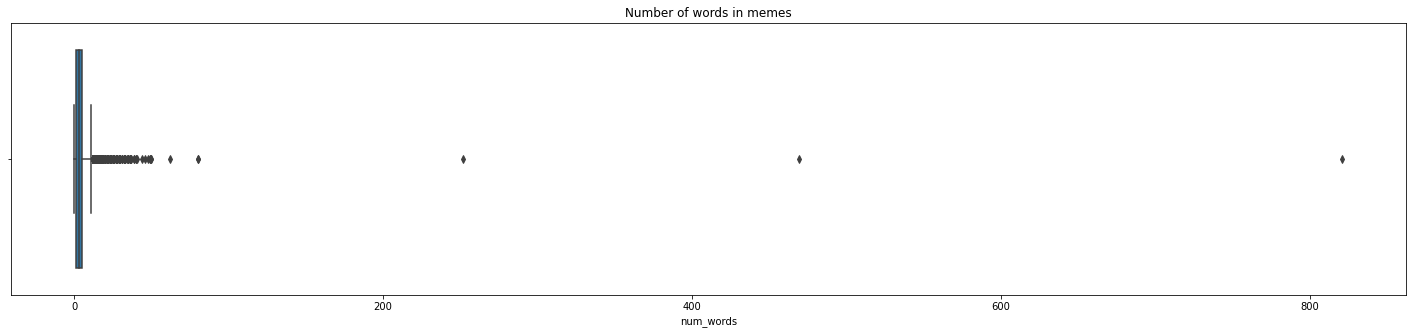

In [20]:
plt.figure(figsize=(25,5))
sns.boxplot(org_data['num_words'])
plt.title('Number of words in memes')
plt.show()

In [21]:
np.percentile(org_data['num_words'],99.9)

41.00300000000607

In [22]:
for i in range(90,101):
  print(i,'percentile : ',np.percentile(org_data['num_words'],i))

90 percentile :  8.0
91 percentile :  9.0
92 percentile :  9.0
93 percentile :  9.0
94 percentile :  10.0
95 percentile :  11.0
96 percentile :  11.0
97 percentile :  13.0
98 percentile :  15.0
99 percentile :  18.0
100 percentile :  821.0


In [23]:
for i in np.arange(99,100.1,0.1):
  print(i,'percentile : ',np.percentile(org_data['num_words'],i))

99.0 percentile :  18.0
99.1 percentile :  19.0
99.19999999999999 percentile :  20.0
99.29999999999998 percentile :  21.0
99.39999999999998 percentile :  22.0
99.49999999999997 percentile :  24.0
99.59999999999997 percentile :  27.0
99.69999999999996 percentile :  30.0
99.79999999999995 percentile :  35.0
99.89999999999995 percentile :  41.00299999997878
99.99999999999994 percentile :  820.9999999974389


In [24]:
org_data = org_data[org_data['num_words']<=75]

In [25]:
org_data.shape[0]

12995

In [26]:
org_data.drop(['created_utc','subreddit','url'], axis=1, inplace=True)

In [27]:
org_data['is_original_content'] = org_data['is_original_content'].astype('int')

In [28]:
org_data['over_18'] = org_data['over_18'].astype('int')

In [29]:
top_5_features = org_data[org_data['score']>np.percentile(org_data['score'],95)]['img_feature']
least_5_features = org_data[org_data['score']<np.percentile(org_data['score'],5)]['img_feature']

In [30]:
#list data are in form of string, converting them to list
from ast import literal_eval
top_5_features = top_5_features.apply(literal_eval)
least_5_features = least_5_features.apply(literal_eval)

In [31]:
#storing all the words present im top 5% features
top_features_list=[]
for value in top_5_features:
    top_features_list.extend(value)

In [32]:
#storing all the words present im bottom 5% features
least_features_list=[]
for value in least_5_features:
    least_features_list.extend(value)

Getting top 10 **shared** objects

In [33]:
top_objects = pd.DataFrame(top_features_list).value_counts()[:11].index.to_frame(index=False)[0]

In [34]:
least_objects = pd.DataFrame(least_features_list).value_counts()[:10].index.to_frame(index=False)[0]

In [35]:
common_objs = set(top_objects).intersection(set(least_objects))

Getting top 10 **most popular** objects which are not shared

In [36]:
top_objects = pd.DataFrame(top_features_list).value_counts()[:32].index.to_frame(index=False)[0]

In [37]:
least_objects = pd.DataFrame(least_features_list).value_counts()[:32].index.to_frame(index=False)[0]

In [38]:
most_pop_objcts = set(top_objects) - set(least_objects)

Getting top 10 **least popular** objects which are not shared

In [39]:
least_objects = pd.DataFrame(least_features_list).value_counts()[-10:].index.to_frame(index=False)[0]

In [40]:
top_objects = pd.DataFrame(top_features_list).value_counts()[:47].index.to_frame(index=False)[0]

In [41]:
least_pop_objcts = set(least_objects) - set(top_objects)

In [42]:
#showing top 10 words in top 5%, bottom 5% and shared data
from prettytable import PrettyTable
x = PrettyTable()
x.add_column("Shared",list(common_objs))
x.add_column("Top 5%",list(most_pop_objcts))
x.add_column("Bottom 5%",list(least_pop_objcts))
print(x)

+---------------+------------------+---------------+
|     Shared    |      Top 5%      |   Bottom 5%   |
+---------------+------------------+---------------+
|    envelope   |     fur_coat     |    missile    |
|   comic_book  | military_uniform |   limousine   |
| digital_clock |      stage       |    obelisk    |
|      menu     |   analog_clock   |    mailbox    |
| jigsaw_puzzle |    hair_spray    |      mink     |
|     screen    |    Chihuahua     |   neck_brace  |
|    monitor    |      cinema      |    library    |
|   scoreboard  |     ski_mask     | mountain_bike |
|  book_jacket  |     toyshop      |    necklace   |
|    web_site   |       wig        |     llama     |
+---------------+------------------+---------------+


In [43]:
#list in img_feature column are in form of string, converting them to list
org_data['img_feature'] = org_data['img_feature'].apply(literal_eval)

In [44]:
#now combining all elements of list as one string
org_data['img_feature'] = org_data['img_feature'].apply(lambda x: ' '.join(map(str, x)))

In [45]:
#storing all the 30 words so that we can use them during bag of words creation
vocab_word = []
#vocab_word.extend(list(most_pop_objcts))
vocab_word.extend(list(least_pop_objcts))
vocab_word.extend(list(common_objs))

In [46]:
#using countvectorizer to create bag of words
from sklearn.feature_extraction.text import CountVectorizer

In [47]:
Countvector = CountVectorizer(vocabulary=vocab_word)

In [50]:
image_fea_vector = Countvector.fit_transform(org_data['img_feature'])

In [52]:
image_fea_vector = pd.DataFrame(image_fea_vector.toarray(),columns=Countvector.get_feature_names())

In [53]:
#joining all bag of word features to original dataset
org_data = org_data.reset_index().join(image_fea_vector)

In [54]:
org_data.drop(['index','img_feature'], axis=1, inplace=True)

In [55]:
#saving the dataset
org_data.to_csv('df_clean.csv', index=False)

## **Explorative Data Analysis**

In [57]:
org_data_EDA= pd.read_csv('/content/drive/MyDrive/CS 2/df_clean.csv')

In [58]:
org_data_EDA.head()

,is_original_content,num_comments,over_18,subreddit_subscribers,upvote_ratio,thumbnail_height,thumbnail_width,score,Sentiment_Score,text,num_words,avg_h,avg_s,avg_v,img_feature_pred,dank_or_not,hour,missile,limousine,obelisk,mailbox,mink,neck_brace,library,mountain_bike,necklace,llama,envelope,comic_book,digital_clock,menu,jigsaw_puzzle,screen,monitor,scoreboard,book_jacket,web_site
0,0,4,0,1396025,1.0,140.0,140.0,7.163196e-07,0.48,whatev,1,0,0,0,"[0.05935011, 0.047493964, 0.034131162]",0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
1,0,4,0,4363172,1.0,140.0,140.0,2.291911e-07,0.50,NaN,0,0,0,0,"[0.05935011, 0.047493964, 0.034131162]",0,12,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
2,0,2,0,14613900,1.0,140.0,140.0,6.842800e-08,0.50,yourselfon choci,2,0,0,0,"[0.067652605, 0.06469549, 0.056321584]",0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,14629522,1.0,131.0,140.0,6.835493e-08,0.10,becau stonk massiv wallstreetbet badredditor b...,6,0,0,0,"[0.9843156, 0.0043508904, 0.0033883443]",0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,1,0,14603384,1.0,121.0,140.0,6.847728e-08,0.46,guyswhen today happen januari first shine,6,0,0,0,"[0.86468834, 0.029700553, 0.0038205122]",0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


# <br><br>Exploratory Data Analysis<br>

In [60]:
#Dividing hours in six groups, each group has four hour timeframe. 
hour_range = []
for i in org_data_EDA['hour']:
  if i>=0 and i<=4:
    hour_range.append('12am-4am')
  elif i>4 and i<=8:
    hour_range.append('4am-8am')
  elif i>8 and i<=12:
    hour_range.append('8am-12pm')
  elif i>12 and i<=16:
    hour_range.append('12pm-4pm')
  elif i>16 and i<=20:
    hour_range.append('4pm-8pm')
  elif i>20 and i<=23:
    hour_range.append('8pm-12am')

In [61]:
org_data_EDA['hour_range'] = hour_range

In [62]:
'''
groupby the dataset on hour_range column and getting mean of dank_or_not column in these timeframes
so that we can find relation between timeframe and dankness of the memes.
'''
hr_grpby = org_data_EDA.groupby('hour_range')['dank_or_not'].mean()

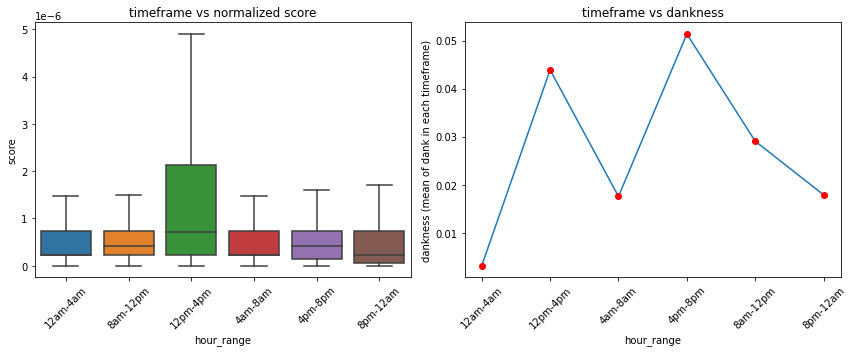

In [63]:
#plotting graphs
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.boxplot(x='hour_range', y='score', data=org_data_EDA,showfliers=False)
plt.title('timeframe vs normalized score')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.plot(hr_grpby.index,hr_grpby.values)
plt.plot(hr_grpby.index,hr_grpby.values, 'ro')
plt.title('timeframe vs dankness')
plt.xlabel('hour_range')
plt.ylabel('dankness (mean of dank in each timeframe)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Sentiment score vs Normalized score
Here I am trying to find, what should be the sentiment of text in the meme to be dank.

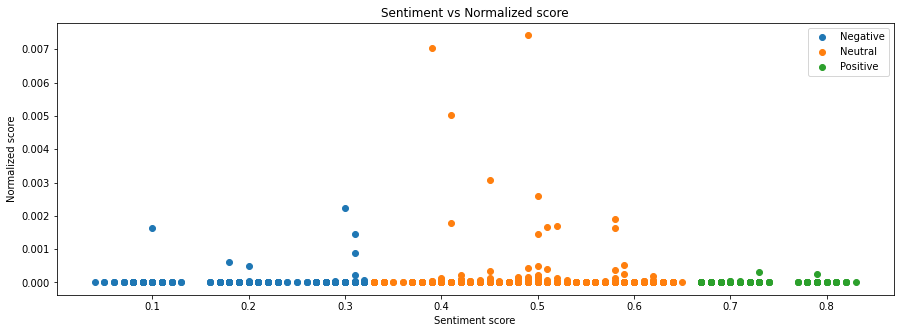

In [68]:
#plotting negative, neutral and positive sentiments on same graph
plt.figure(figsize=(15,5))
#positive
plt.scatter(org_data_EDA[org_data_EDA['Sentiment_Score']<0.33]['Sentiment_Score'], org_data_EDA[org_data_EDA['Sentiment_Score']<0.33]['score'])
#neutral
plt.scatter(org_data_EDA[(org_data_EDA['Sentiment_Score']>=0.33) & (org_data_EDA['Sentiment_Score']<0.66)]['Sentiment_Score'], org_data_EDA[(org_data_EDA['Sentiment_Score']>=0.33) & (org_data_EDA['Sentiment_Score']<0.66)]['score'])
#negative
plt.scatter(org_data_EDA[org_data_EDA['Sentiment_Score']>0.66]['Sentiment_Score'], org_data_EDA[org_data_EDA['Sentiment_Score']>0.66]['score'])

plt.title('Sentiment vs Normalized score')
plt.xlabel('Sentiment score')
plt.ylabel('Normalized score')
plt.legend(['Negative','Neutral','Positive'])
plt.show()

Text length vs Normalized score

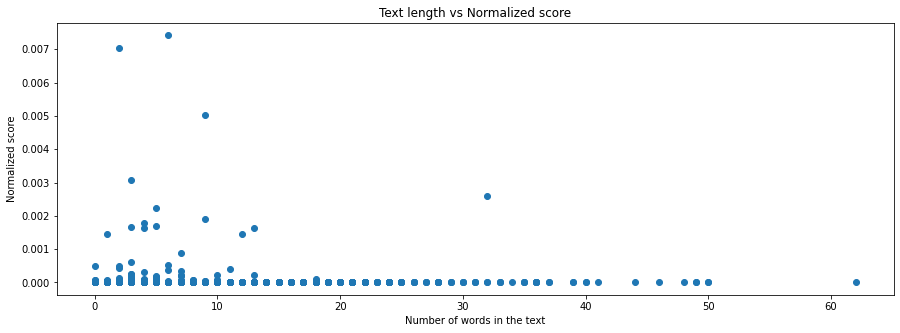

In [69]:
plt.figure(figsize=(15,5))
plt.scatter(org_data_EDA['num_words'], org_data_EDA['score'])

plt.title('Text length vs Normalized score')
plt.xlabel('Number of words in the text')
plt.ylabel('Normalized score')
plt.show()

**Word cloud for text column**

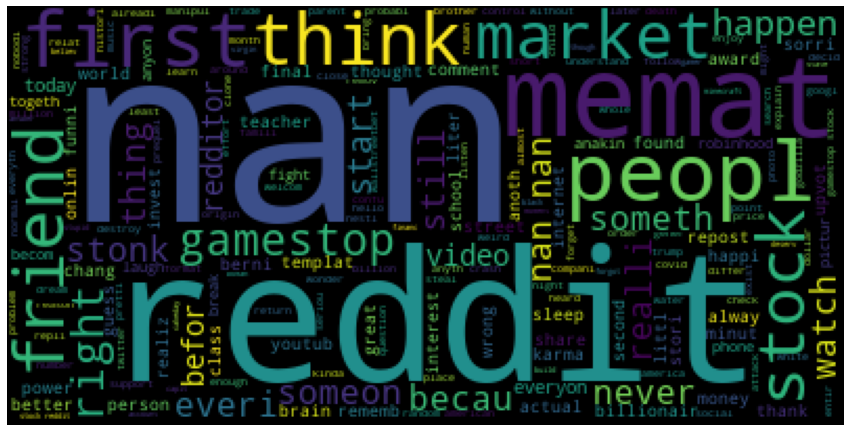

In [70]:
from wordcloud import WordCloud
plt.figure(figsize=(15,10))
text = " ".join(i for i in org_data_EDA['text'].astype(str))
wordcloud = WordCloud().generate(text)
# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# **Number of comments vs Normalized score**

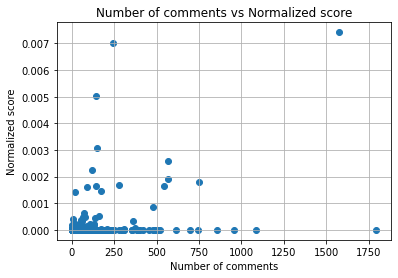

In [71]:
plt.scatter(org_data_EDA['num_comments'], org_data_EDA['score'])
plt.title('Number of comments vs Normalized score')
plt.xlabel('Number of comments')
plt.ylabel('Normalized score')
plt.grid()
plt.show()

# **Thumbnail height and width vs normalized score**

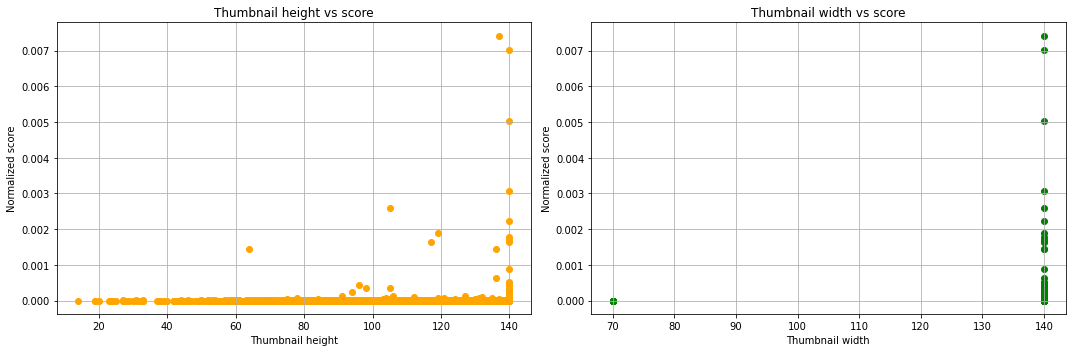

In [72]:
#thumbnail height
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(org_data_EDA['thumbnail_height'], org_data_EDA['score'], color='orange')
plt.title('Thumbnail height vs score')
plt.xlabel('Thumbnail height')
plt.ylabel('Normalized score')
plt.grid()

#thumbnail width
plt.subplot(1,2,2)
plt.scatter(org_data_EDA['thumbnail_width'], org_data_EDA['score'],color='green')
plt.title('Thumbnail width vs score')
plt.xlabel('Thumbnail width')
plt.ylabel('Normalized score')
plt.grid()

plt.tight_layout()
plt.show()